In [3]:
# finds the best combination/ensemble based on the trained models
!nnUNetv2_find_best_configuration 001 -c 3d_fullres


***All results:***
nnUNetTrainer__nnUNetPlans__3d_fullres: 0.7169128277669848

*Best*: nnUNetTrainer__nnUNetPlans__3d_fullres: 0.7169128277669848

***Determining postprocessing for best model/ensemble***
Removing all but the largest foreground region did not improve results!
Removing all but the largest component for 1 did not improve results! Dice before: 0.89743 after: 0.89485
Results were improved by removing all but the largest component for 2. Dice before: 0.5364 after: 0.53691

***Run inference like this:***

nnUNetv2_predict -d Dataset001_Pancreas -i INPUT_FOLDER -o OUTPUT_FOLDER -f  0 1 2 3 4 -tr nnUNetTrainer -c 3d_fullres -p nnUNetPlans

***Once inference is completed, run postprocessing like this:***

nnUNetv2_apply_postprocessing -i OUTPUT_FOLDER -o OUTPUT_FOLDER_PP -pp_pkl_file C:\Users\Leo\Documents\UHN-MedImg3D-ML-quiz\nnUNet_results\Dataset001_Pancreas\nnUNetTrainer__nnUNetPlans__3d_fullres\crossval_results_folds_0_1_2_3_4\postprocessing.pkl -np 8 -plans_json C:\Users\

In [ ]:
# more options
#!nnUNetv2_find_best_configuration -h

In [4]:
# ***Run inference like this:***
!nnUNetv2_predict -d Dataset002_PancreasLesion -i C:\Users\Leo\Documents\UHN-MedImg3D-ML-quiz\nnUnet_raw\Dataset002_PancreasLesion\imagesTs -o C:\Users\Leo\Documents\UHN-MedImg3D-ML-quiz\validation_predictions\nnUnet_3d_fullres_resenc_Oct29 -f  0 1 -tr nnUNetTrainer -c 3d_fullres -p nnUNetResEncUNetMPlans



#######################################################################
Please cite the following paper when using nnU-Net:
Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
#######################################################################

There are 36 cases in the source folder
I am process 0 out of 1 (max process ID is 0, we start counting with 0!)
There are 36 cases that I would like to predict

Predicting quiz_0_168:
perform_everything_on_device: True
sending off prediction to background worker for resampling and export
done with quiz_0_168

Predicting quiz_0_171:
perform_everything_on_device: True
sending off prediction to background worker for resampling and export
done with quiz_0_171

Predicting quiz_0_174:
perform_everything_on_device: True
sending off prediction to background worker for resampling and export
done wi

C:\Users\Leo\OneDrive\Documents\GitHub\WangLabQuiz\nnUNet\nnunetv2\inference\predict_from_raw_data.py:84: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.lo

In [5]:
#***Once inference is completed, run postprocessing like this:***

!nnUNetv2_apply_postprocessing -i C:\Users\Leo\Documents\UHN-MedImg3D-ML-quiz\validation_predictions\nnUnet_3d_fullres_Oct5 -o C:\Users\Leo\Documents\UHN-MedImg3D-ML-quiz\test_predictions\nnUnet_3d_fullres_Oct5_PP -pp_pkl_file C:\Users\Leo\Documents\UHN-MedImg3D-ML-quiz\nnUNet_results\Dataset001_Pancreas\nnUNetTrainer__nnUNetPlans__3d_fullres\crossval_results_folds_0_1_2_3_4\postprocessing.pkl -np 8 -plans_json C:\Users\Leo\Documents\UHN-MedImg3D-ML-quiz\nnUNet_results\Dataset001_Pancreas\nnUNetTrainer__nnUNetPlans__3d_fullres\crossval_results_folds_0_1_2_3_4\plans.json

In [5]:
### IMPORTS
import os
import glob
import json
#import util

import numpy as np
import pandas as pd
import random
import math
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from torch.autograd import Variable
import torch.nn.init as init

from collections import defaultdict
from collections import Counter

from datetime import datetime

import SimpleITK as sitk

def get_dice_score(x, y, label):
    ''' 
    returns dice score for *label* (1 = pancreas, 2 = lesion)    
    
    formula = 2 * (intersection) / (x + y)
    '''
    x = np.equal(x, label)
    y = np.equal(y, label)

    return (2*np.sum(x*y)/ (np.sum(x) + np.sum(y)))

In [9]:
### manually checking the dice scores

original_dir = r'C:\Users\Leo\Documents\UHN-MedImg3D-ML-quiz\validation'
subtype_folders = ['subtype0', 'subtype1', 'subtype2']

predicted_dir = r'C:\Users\Leo\Documents\UHN-MedImg3D-ML-quiz\validation_predictions\nnUnet_3d_fullres_resenc_Oct29'


# for each file in the folder
#   compare the image to the original
#   calculate the dice score for pancreas and lesion
#   tally the results in a csv file

csv_file = 'nnUnet_3d_fullres_resenc_Oct29'
csv_path = os.path.join(predicted_dir, csv_file)

df = []
firstrow = True

for i, subtype in enumerate(subtype_folders):    
    subtype_dir = os.path.join(original_dir, subtype)
    original_masks = [os.path.join(subtype_dir, (file_name.split('_0000')[0] + '.nii')) for file_name in os.listdir(subtype_dir) if '0000' in file_name]

    for original_mask in original_masks:
        original_mask_name = original_mask.split('\\')[-1]
        predicted_mask_name = original_mask_name.split('_')[0] + '_' + str(subtype[-1])+ '_' + original_mask_name.split('_')[2]
        ID = predicted_mask_name.split('_')[-1].split('.nii')[0]
        
        original_seg = sitk.ReadImage(os.path.join(subtype_dir, original_mask), sitk.sitkInt16)
        predicted_seg = sitk.ReadImage(os.path.join(predicted_dir, predicted_mask_name), sitk.sitkInt16)

        original_seg_npy = sitk.GetArrayFromImage(original_seg)
        predicted_seg_npy = sitk.GetArrayFromImage(predicted_seg)
        
        pancreas_dice = get_dice_score(original_seg_npy, predicted_seg_npy, 1)
        lesion_dice = get_dice_score(original_seg_npy, predicted_seg_npy, 2)

        row_df = pd.DataFrame({'ID':ID, 'subtype':subtype, 'pancreas_dice':pancreas_dice, 'lesion_dice':lesion_dice}, index=[0])
        
        if firstrow == True:
            df = row_df
            firstrow = False
        else:
            df = pd.concat([df, row_df])
            

df.to_csv(csv_path)

In [10]:
original_dir = r'C:\Users\Leo\Documents\UHN-MedImg3D-ML-quiz\validation'
subtype_folders = ['subtype0', 'subtype1', 'subtype2']
predicted_dir = r'C:\Users\Leo\Documents\UHN-MedImg3D-ML-quiz\validation_predictions\nnUnet_3d_fullres_resenc_Oct29'

csv_file = 'nnUnet_3d_fullres_resenc_Oct29.csv'
csv_path = os.path.join(predicted_dir, csv_file)

df = pd.read_csv(csv_path)

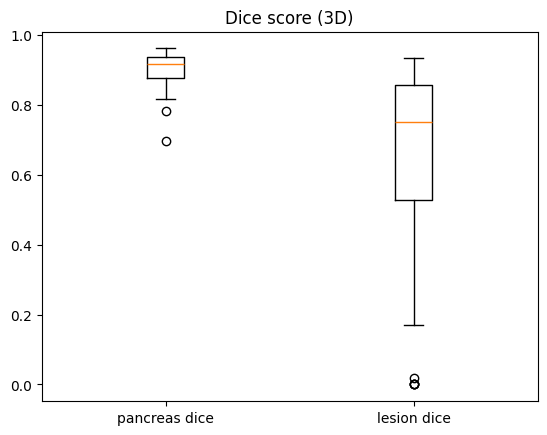

In [10]:
dice_dict = {'pancreas dice': df['pancreas_dice'], 'lesion dice': df['lesion_dice']}

fig, ax = plt.subplots()
ax.boxplot(dice_dict.values())
#ax.violinplot(dice_dict.values(), showmeans=False, showmedians=True)
ax.set_xticklabels(dice_dict.keys())
ax.set_title('Dice score (3D)')
ax.set_yticks(np.arange(0, 1.2, step=0.2))

In [13]:
### calculate statistics

def get_stats(col):
    mean = np.mean(col)
    median = np.median(col)

    return(mean, median)

print('Pancreas dice mean/median: ' + str(get_stats(dice_dict['pancreas dice'])))
print('Lesion dice mean/median: ' + str(get_stats(dice_dict['lesion dice'])))

Pancreas dice mean/median: (0.9017820434210131, 0.9162098645096641)
Lesion dice mean/median: (0.6349654140771607, 0.7524634954511982)


In [48]:
### generating the predictions for the test set

# ***Run inference like this:***
!nnUNetv2_predict -d Dataset001_Pancreas -i C:\Users\Leo\Documents\UHN-MedImg3D-ML-quiz\test -o C:\Users\Leo\Documents\UHN-MedImg3D-ML-quiz\test_predictions\nnUnet_3d_fullres_Oct5 -f  0 1 2 3 4 -tr nnUNetTrainer -c 3d_fullres -p nnUNetPlans




#######################################################################
Please cite the following paper when using nnU-Net:
Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
#######################################################################

There are 72 cases in the source folder
I am process 0 out of 1 (max process ID is 0, we start counting with 0!)
There are 72 cases that I would like to predict

Predicting quiz_037:
perform_everything_on_device: True
sending off prediction to background worker for resampling and export
done with quiz_037

Predicting quiz_045:
perform_everything_on_device: True
sending off prediction to background worker for resampling and export
done with quiz_045

Predicting quiz_047:
perform_everything_on_device: True
sending off prediction to background worker for resampling and export
done with quiz_04

C:\Users\Leo\OneDrive\Documents\GitHub\WangLabQuiz\nnUNet\nnunetv2\inference\predict_from_raw_data.py:84: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.lo

In [49]:
#***Once inference is completed, run postprocessing like this:***

!nnUNetv2_apply_postprocessing -i C:\Users\Leo\Documents\UHN-MedImg3D-ML-quiz\test_predictions\nnUnet_3d_fullres_Oct5 -o C:\Users\Leo\Documents\UHN-MedImg3D-ML-quiz\test_predictions\nnUnet_3d_fullres_Oct5_PP -pp_pkl_file C:\Users\Leo\Documents\UHN-MedImg3D-ML-quiz\nnUNet_results\Dataset001_Pancreas\nnUNetTrainer__nnUNetPlans__3d_fullres\crossval_results_folds_0_1_2_3_4\postprocessing.pkl -np 8 -plans_json C:\Users\Leo\Documents\UHN-MedImg3D-ML-quiz\nnUNet_results\Dataset001_Pancreas\nnUNetTrainer__nnUNetPlans__3d_fullres\crossval_results_folds_0_1_2_3_4\plans.json